In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd
from minijpas_LF_and_puricomp import effective_volume
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from my_functions import schechter
from multiprocessing import Pool
from LAEs.my_functions import *
from LAEs.plot_puricomp2d import *
from scipy import linalg

In [2]:
%matplotlib inline

In [3]:
def mask_puricomp(puri, comp, min_puri=0.2, min_comp=0.2):
    return (puri > min_puri) & (comp > min_comp)

min_N_bin = 0.0001

In [4]:
# My LF
nbs_list = [[1, 5], [4, 8], [7, 11], [10, 14], [13, 17], [16, 20]]
qso_factor = 1.0
comb_nbs_list = nbs_list
survey_list = [f'minijpasAEGIS00{i}' for i in range(1, 4 + 1)] + ['jnep']
w_central = central_wavelength()
w_lya = 1215.67
nb_fwhm_Arr = nb_fwhm(np.arange(60))
L_binning = np.load('npy/L_nb_err_binning.npy')
b = np.log10(L_binning)
LF_bins = np.array([(b[i] + b[i + 1]) / 2 for i in range(len(b) - 1)])
bin_width = np.array([b[i + 1] - b[i] for i in range(len(b) - 1)])

total_volume = 0.
for [this_nb_min, this_nb_max] in comb_nbs_list:
    total_volume += effective_volume(this_nb_min, this_nb_max, 'both')
masked_volume = None
hist_mat = None
LF_raw = None
total_puri_list = np.load('npy/total_puri_list.npy')
total_comp_list = np.load('npy/total_comp_list.npy')

for i, [nb1, nb2] in enumerate(comb_nbs_list):
    pathname = f'Luminosity_functions/LF_r17-24_nb{nb1}-{nb2}_ew30_ewoth100_nb_{qso_factor:0.1f}'
    comp_list, _, _, puri_list, comp_den_list, _, _, puri_den_list, puricomp_bins = \
        load_puricomp1d(pathname)

    # Bin centers
    bc = [puricomp_bins[i: i + 2].sum() * 0.5 for i in range(len(puricomp_bins) - 1)]

    this_puri = np.interp(LF_bins, bc, total_puri_list[i])
    this_comp = np.interp(LF_bins, bc, total_comp_list[i])
    this_hist = None
    for survey_name in survey_list:
        pathname = f'Luminosity_functions/LF_r17-24_nb{nb1}-{nb2}_ew30_ewoth100_nb_{qso_factor:0.1f}'
        filename_hist = f'{pathname}/hist_i_mat_{survey_name}.npy'
        hist_i_mat = np.load(filename_hist)

        this_field_LF = hist_i_mat / effective_volume(nb1, nb2, survey_name) / bin_width

        if this_hist is None:
            this_hist = hist_i_mat
            field_LF_mat = this_field_LF
        else:
            this_hist += hist_i_mat
            field_LF_mat = np.vstack([field_LF_mat, this_field_LF])

    this_hist = this_hist / total_volume / bin_width

    this_volume = np.ones_like(LF_bins) * effective_volume(nb1, nb2, 'both')

    filename_dict = f'{pathname}/LFs.pkl'
    with open(filename_dict, 'rb') as file:
        this_LF_raw = pickle.load(file)['LF_total_raw'] * this_volume
        if LF_raw is None:
            LF_raw = this_LF_raw
        else:
            LF_raw += this_LF_raw
        
    # Set masked bins by puricomp_mask to 0
    N_median_hist = np.nanmedian(this_hist, axis=0) * total_volume * bin_width
    puricomp_mask = mask_puricomp(this_puri, this_comp) & (N_median_hist >= min_N_bin)
    this_hist[:, ~puricomp_mask] = 0.
    this_volume[~puricomp_mask] = 0.

    if masked_volume is None:
        masked_volume = this_volume
    else:
        masked_volume += this_volume

    if hist_mat is None:
        hist_mat = this_hist
    else:
        hist_mat = hist_mat + this_hist

hist_mat = hist_mat * total_volume / masked_volume

# Field by field variation
field_L_LF_err_percentiles = np.nanpercentile(field_LF_mat, [16, 50, 84], axis=0)
field_LF_err_plus = field_L_LF_err_percentiles[2] - field_L_LF_err_percentiles[1]
field_LF_err_minus = field_L_LF_err_percentiles[1] - field_L_LF_err_percentiles[0]

L_LF_err_percentiles = np.nanpercentile(hist_mat, [16, 50, 84], axis=0)
LF_err_plus = L_LF_err_percentiles[2] - L_LF_err_percentiles[1]
LF_err_minus = L_LF_err_percentiles[1] - L_LF_err_percentiles[0]
hist_median = L_LF_err_percentiles[1]

mask_low_N = (LF_raw < min_N_bin)
for h in [LF_err_plus, LF_err_minus, hist_median]:
    h[mask_low_N] = 0.

volwid = total_volume * bin_width

load_LF_name = '/home/alberto/cosmos/LAEs/Luminosity_functions/Total_LF'

yerr_plus = np.load(f'{load_LF_name}/LF_err_plus.npy')
yerr_minus = np.load(f'{load_LF_name}/LF_err_minus.npy')

yerr_minus = (yerr_minus ** 2 + hist_median / volwid) ** 0.5
yerr_plus = (yerr_plus ** 2 + hist_median / volwid) ** 0.5


LF_dict = {
    'LF_bins': LF_bins,
    'LF_total': hist_median,
    'LF_total_err': [yerr_minus, yerr_plus]
}

LF_yerr_minus = yerr_minus
LF_yerr_plus = yerr_plus
LF_phi = LF_dict['LF_total']
LF_bin = LF_dict['LF_bins']

/home/alberto/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [5]:
def covmat_simple(xiallreal):

    nbins, nreals = xiallreal.shape

    ximeans = xiallreal.mean(axis=1)
    xistds = xiallreal.std(axis=1, ddof=1)
    covmat = np.empty((nbins, nbins), float)
    corrmat = np.empty((nbins, nbins), float)

    for i in range(nbins):
        for j in range(nbins):
            covmat[i, j] = ((xiallreal[i] - ximeans[i]) *
                            (xiallreal[j] - ximeans[j])).sum()/float(nreals - 1)
            corrmat[i, j] = covmat[i, j]/(xistds[i]*xistds[j])

    return covmat, corrmat


def compute_invcovmat(hist_mat, where_fit):
    this_hist_mat = hist_mat.T[where_fit]
    this_hist_mat[~np.isfinite(this_hist_mat)] = 0.
    covmat = covmat_simple(this_hist_mat)[0]
    invcovmat = linalg.inv(covmat)
    return invcovmat


In [6]:
# The fitting surve
def sch_fit(Lx, Phistar, Lstar, alpha):
    return schechter(Lx, 10 ** Phistar, 10 ** Lstar, alpha) * Lx * np.log(10)

In [7]:
def chi2_fullmatrix(data_vals, inv_covmat, model_predictions):
    """
    Given a set of data points, its inverse covariance matrix and the
    corresponding set of model predictions, computes the standard chi^2
    statistic (using the full covariances)
    """

    y_diff = data_vals - model_predictions
    return np.dot(y_diff, np.dot(inv_covmat, y_diff))

def prior_f(theta):
    Phistar0 = theta[0]
    Lstar0 = theta[1]
    alpha0 = theta[2]
    Phistar_range = (-8 < Phistar0 < -4)
    Lstar_range = (43 < Lstar0 < 46)
    alpha_range = (-2.5 < alpha0 < -0.01)

    if Phistar_range & Lstar_range & alpha_range:
        return 0.
    else:
        return -np.inf

def log_likelihood(theta, Lx, Phi, invcovmat):
    Phistar0 = theta[0]
    Lstar0 = theta[1]
    alpha0 = theta[2]

    model_Arr = sch_fit(Lx, Phistar0, Lstar0, alpha0)

    chi2 = chi2_fullmatrix(model_Arr, invcovmat, Phi)

    return -0.5 * chi2

def log_p(theta, Lx, Phi, invcovmat):
    return log_likelihood(theta, Lx, Phi, invcovmat) + prior_f(theta)

In [8]:
## MCMC parameters ##
N_walkers = 1000
N_burn = 100_000
N_steps = 10_000

# Error to use
yerr = (LF_yerr_plus + LF_yerr_minus) * 0.5
yerr[LF_phi == 0] = np.inf

# In which LF bins fit
where_fit = np.isfinite(yerr) & (LF_bins > 40) & (LF_bins < 46)

# invcovmat = compute_invcovmat(hist_mat, where_fit)
### Let's use only yerr:
yerr = (LF_yerr_plus + LF_yerr_minus) * 0.5
# yerr[LF_phi == 0] = np.inf
covmat = np.eye(sum(where_fit)) * yerr[where_fit].reshape(-1, 1) ** 2
covmat[np.isnan(covmat)] = 0.
invcovmat = linalg.inv(covmat)
###

theta0 = np.zeros((N_walkers, 3))
theta0[:, 0] = np.random.normal(-6, 1e-3, N_walkers)
theta0[:, 1] = np.random.normal(44.5, 1e-3, N_walkers)
theta0[:, 2] = np.random.normal(-1.5, 1e-3, N_walkers)

args = (10**LF_bins[where_fit], LF_phi[where_fit], invcovmat)

with Pool() as pool:
    # Ensemble the sampler
    sampler = emcee.EnsembleSampler(N_walkers, 3, log_p, args=args, pool=pool)
    # Run the MCMC
    state = sampler.run_mcmc(theta0, N_burn, progress=True, thin=10);
    sampler.reset()
    state = sampler.run_mcmc(state, N_burn, progress=True, thin=10);
    sampler.reset()
    sampler.run_mcmc(state, N_steps, progress=True, thin=1)

# autocorr_t = sampler.get_autocorr_time()
# print(f'Autocorrelation time: {autocorr_t}')

100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 24.25it/s]


(910000, 3)
Best fit:
Phi* = -6.63426 + 0.53693 - 0.50523,
L* = 45.10914 + 0.57171 - 0.55387,
alpha = -1.25643 + 0.84679 - 0.84831


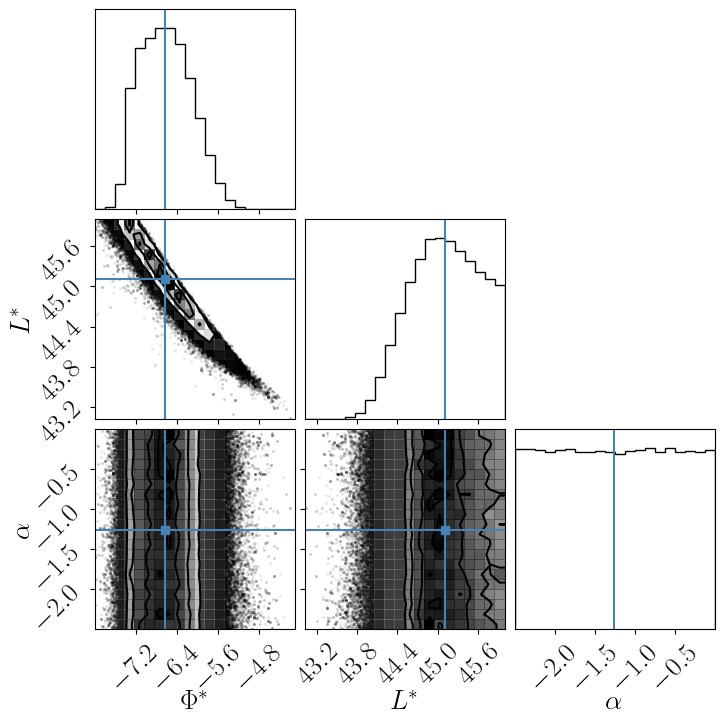

In [10]:
N_discard = N_steps // 100 * 9
flat_samples = sampler.get_chain(discard=N_discard, thin=1, flat=True)
print(flat_samples.shape)
labels = [r'$\Phi^*$', r'$L^*$', r'$\alpha$', 'log_f']

fit_params = np.median(flat_samples, axis=0)
fit_params_perc84 = np.percentile(flat_samples, [84], axis=0)[0]
fit_params_perc16 = np.percentile(flat_samples, [16], axis=0)[0]
fit_params_err_up = fit_params_perc84 - fit_params
fit_params_err_down = fit_params - fit_params_perc16
print(f'Best fit:\nPhi* = {fit_params[0]:0.5f} + {fit_params_err_up[0]:0.5f} - {fit_params_err_down[0]:0.5f},\n'
      f'L* = {fit_params[1]:0.5f} + {fit_params_err_up[1]:0.5f} - {fit_params_err_down[1]:0.5f},\n'
      f'alpha = {fit_params[2]:0.5f} + {fit_params_err_up[2]:0.5f} - {fit_params_err_down[2]:0.5f}')

[Phistar_fit, Lstar_fit, alpha_fit] = list(fit_params)

fig = corner.corner(flat_samples, labels=labels,
                    truths=[Phistar_fit, Lstar_fit, alpha_fit])
plt.show(block=False)

# Save the chain
np.save('npy/mcmc_schechter_fit_chain', flat_samples)

In [11]:
# Covariance matrix of the parameters
params_covmat, params_corrmat = covmat_simple(flat_samples.T)

print(params_corrmat)

[[ 1.00000000e+00 -9.76419349e-01 -5.04487520e-04]
 [-9.76419349e-01  1.00000000e+00 -1.02137044e-04]
 [-5.04487520e-04 -1.02137044e-04  1.00000000e+00]]


In [12]:
# Load fits from Spinoso+2020
pathname = '/home/alberto/almacen/literature_LF_data/LF_data_SpinosoEtAl2020/JPLUS_LFs_for_Alberto/new'
fit_jplus0395 = pd.read_csv(f'{pathname}/20230122_J0395_full_best_Schechter_fit.txt',
                            header=0, sep=',')
fit_jplus0410 = pd.read_csv(f'{pathname}/20230122_J0410_full_best_Schechter_fit.txt',
                            header=0, sep=',')
fit_jplus0430 = pd.read_csv(f'{pathname}/20230122_J0430_full_best_Schechter_fit.txt',
                            header=0, sep=',')
fit_jplus0515 = pd.read_csv(f'{pathname}/20230122_J0515_full_best_Schechter_fit.txt',
                            header=0, sep=',')

jplus_z_list = [2.25, 2.37, 2.54, 3.24]

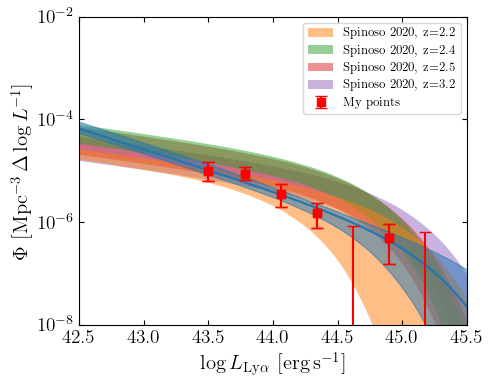

In [13]:
from my_functions import double_schechter
fig, ax = plt.subplots(figsize=(5, 4))


# Compute fit for all steps in chain
Phi_fit_i = []
Lx = np.logspace(42, 46, 1000)
for ii, step in enumerate(flat_samples[::-1]):
    if ii == 10_000:
        break
    Phi_fit_i.append(sch_fit(Lx, step[0], step[1], step[2]))
Phi_fit_84 = np.percentile(Phi_fit_i, 84, axis=0)
Phi_fit_16 = np.percentile(Phi_fit_i, 16, axis=0)

# My fit
Phi_fit = sch_fit(Lx, Phistar_fit, Lstar_fit, alpha_fit)
ax.plot(np.log10(Lx), Phi_fit)
ax.fill_between(np.log10(Lx), Phi_fit_16, Phi_fit_84, alpha=0.5, color='C0')

ax.errorbar(LF_bin[where_fit], LF_phi[where_fit],
            yerr=[LF_yerr_minus[where_fit], LF_yerr_plus[where_fit]],
            fmt='s', color='r', capsize=4, label='My points')
ax.errorbar(LF_bin, LF_phi,
            yerr=[LF_yerr_minus, LF_yerr_plus],
            fmt='s', color='r', capsize=4,
            markerfacecolor='none')

ax.set_yscale('log')
ax.set_ylim(1e-8, 5e-3)
ax.set_xlim(42.5, 45.5)


# Plot the reference LF curves
for kkk, jplus_LF in enumerate([fit_jplus0395, fit_jplus0410, fit_jplus0430, fit_jplus0515]):
    this_color = f'C{kkk + 1}'
    # ax.plot(jplus_LF['LogL'], jplus_LF['Phi'], color=this_color)
    ax.fill_between(jplus_LF['LogL'], jplus_LF['Phi_pcntile16'], jplus_LF['Phi_pcntile84'],
                    color=this_color, alpha=0.5, lw=0, zorder=-99-kkk,
                    label=f'Spinoso 2020, z={jplus_z_list[kkk]:0.1f}')

ax.set_ylim(1e-8, 1e-2)
ax.set_xlim(42.5, 45.5)
ax.set_yscale('log')

ax.set_xlabel(r'$\log L_{\mathrm{Ly}\alpha}$ [erg$\,$s$^{-1}$]', fontsize=15)
ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}\,\Delta\log L^{-1}$]', fontsize=15)

ax.tick_params(labelsize=14, direction='in', which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.legend(fontsize=9)
plt.show(block=False)